<a href="https://colab.research.google.com/github/ZulfanAlfarra/perbandingan-resolusi-gambar/blob/main/bahan_PI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import zipfile

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from tqdm.auto import tqdm
from typing import Tuple, List, Dict
from timeit import default_timer as timer

In [2]:
# ! kaggle datasets download limitmax14/sampah

In [3]:
# data_path = Path("data")
# image_path = data_path / "sampah"

# with zipfile.ZipFile("sampah.zip", "r") as zip_ref:
#   print("Unziping file...")
#   zip_ref.extractall(image_path)

# os.remove("sampah.zip")

In [4]:
# train_dir = image_path / "Data" / "Train"
# test_dir = image_path / "Data" / "Test"

# train_dir, test_dir

In [5]:
! kaggle datasets download quangtheng/garbage-classification-6-classes-775class

Dataset URL: https://www.kaggle.com/datasets/quangtheng/garbage-classification-6-classes-775class
License(s): apache-2.0
 94% 47.0M/50.2M [00:02<00:00, 20.6MB/s]
100% 50.2M/50.2M [00:02<00:00, 19.1MB/s]


In [6]:
from sklearn.model_selection import train_test_split
import shutil

data_path_2 = Path("data2")
data_dir = data_path_2 / "sampah-classfication"

with zipfile.ZipFile("garbage-classification-6-classes-775class.zip", "r") as f:
  f.extractall(data_dir)


train_dir_2 = data_path_2 / "train"
test_dir_2 = data_path_2 / "test"

train_dir_2.mkdir(parents=True, exist_ok=True)
test_dir_2.mkdir(parents=True, exist_ok=True)

# Ambil semua kelas (nama subfolder)
classes = [item for item in data_dir.iterdir() if item.is_dir()]

# Iterasi melalui setiap kelas
for class_path in classes:
    class_name = class_path.name

    # Ambil semua file dalam folder kelas
    files = list(class_path.iterdir())

    # Jika tidak ada file, skip kelas ini
    if len(files) == 0:
        print(f"Skipping empty class folder: {class_name}")
        continue

    # Split files into train and test (80% train, 20% test)
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    # Buat folder kelas di train dan test
    class_train_dir = train_dir_2 / class_name
    class_test_dir = test_dir_2 / class_name
    class_train_dir.mkdir(parents=True, exist_ok=True)
    class_test_dir.mkdir(parents=True, exist_ok=True)

    # Pindahkan file ke folder train
    for file_path in train_files:
        shutil.move(str(file_path), str(class_train_dir / file_path.name))

    # Pindahkan file ke folder test
    for file_path in test_files:
        shutil.move(str(file_path), str(class_test_dir / file_path.name))

shutil.rmtree(data_dir)

In [7]:
def create_transforms(w: int, h: int):
  """Creating train and test transforms

  args:
    w: Width for size of image
    h: Height for size of image

  returns:
    A tupple of (with_augmented_transform, simple_transform)
  """
  with_augmented_transform = transforms.Compose([
      transforms.Resize((w, h)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomRotation(15),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
  ])

  simple_transform = transforms.Compose([
      transforms.Resize((w, h)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
  ])

  return with_augmented_transform, simple_transform

In [8]:
def create_dataloader(train_dir: str,
                      test_dir: str,
                      train_transform: transforms.Compose,
                      test_transform: transforms.Compose,
                      batch_size: int,
                      num_workers: int):
  """Create training and testing DataLoader

    Takes in a training and testing directory path and turns them into PyTorch Datasets and then into PyTorch DataLoaders

    args:
        train_dir: Path to training directory.
        test_dir: Path to testing directory.
        train_transform: torchvision transforms to perform on training data
        test_transform: torchvision transforms to perform on esting data
        batch_size: Number of sample per batch in each of the dataloaders
        num_workers: An integer fro number of workers per DataLoader.

    returns:
      A tupple of (train_dataloader, test_dataloader, class_names)
  """

  train_data = datasets.ImageFolder(train_dir, train_transform)
  test_data = datasets.ImageFolder(test_dir, test_transform)

  train_dataloader = DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=num_workers,
                                drop_last=True)
  test_dataloader = DataLoader(test_data,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=num_workers,
                               drop_last=True)
  class_names = train_data.classes

  return train_dataloader, test_dataloader, class_names

In [9]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 16
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Model Builder


In [10]:
class CNN_model(nn.Module):
  """
  Args:
    input_shape: An integer indicationg number of input channels
    initial_hidden_units: An integer indicationg of initial hidden units between layers
    output_shape: An integer indicating number of output units
  """
  def __init__(self, input_shape:int, initial_hidden_units: int, output_shape) -> None:
     super().__init__()
     self.conv_block = nn.Sequential(
         nn.Conv2d(in_channels=input_shape, out_channels=initial_hidden_units, kernel_size=3),
         nn.ReLU(),
         nn.MaxPool2d(2,2),
         nn.Conv2d(initial_hidden_units, initial_hidden_units*2, kernel_size=3),
         nn.ReLU(),
         nn.MaxPool2d(2,2),
         nn.Conv2d(initial_hidden_units*2, initial_hidden_units*4, kernel_size=3),
         nn.ReLU(),
         nn.MaxPool2d(2,2),
         nn.Conv2d(initial_hidden_units*4, initial_hidden_units*8, kernel_size=3),
         nn.ReLU(),
         nn.MaxPool2d(2,2)
     )


     self.classifier = None
     self.output_shape = output_shape

  def forward(self, x):
    x = self.conv_block(x)

    if self.classifier is None:
      flattened_size = x.view(x.size(0), -1).size(1)  # Calculate in_features dynamically
      print(x.view(x.size(0), -1).size(1))
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=flattened_size, out_features=self.output_shape)
        ).to(x.device)

    x = self.classifier(x)
    return x

In [11]:
model_0 = CNN_model(input_shape=3, initial_hidden_units=8, output_shape=3).to(device)

torchinfo.summary(model_0, input_size=[1, 3, 64, 64])

256


Layer (type:depth-idx)                   Output Shape              Param #
CNN_model                                [1, 3]                    --
├─Sequential: 1-1                        [1, 64, 2, 2]             --
│    └─Conv2d: 2-1                       [1, 8, 62, 62]            224
│    └─ReLU: 2-2                         [1, 8, 62, 62]            --
│    └─MaxPool2d: 2-3                    [1, 8, 31, 31]            --
│    └─Conv2d: 2-4                       [1, 16, 29, 29]           1,168
│    └─ReLU: 2-5                         [1, 16, 29, 29]           --
│    └─MaxPool2d: 2-6                    [1, 16, 14, 14]           --
│    └─Conv2d: 2-7                       [1, 32, 12, 12]           4,640
│    └─ReLU: 2-8                         [1, 32, 12, 12]           --
│    └─MaxPool2d: 2-9                    [1, 32, 6, 6]             --
│    └─Conv2d: 2-10                      [1, 64, 4, 4]             18,496
│    └─ReLU: 2-11                        [1, 64, 4, 4]             --
│   

## Engine

Contains functions for training and testing a PyTorch model

In [12]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
               """
               Args:
                model: A PyTorch model to be trained
                dataloader: A DataLoader instance for the model to be trained on.
                loss_fn: A PyTorch loss function to minimize
                optimizer: A Pytorch optimzier to help minimize the loss function
                deevice: A target device to compute on.

              Returns:
                A tuple of training loss and training accuracy metrics.
                In the form (train_loss, train_accuracy). For example:

                (0.1112, 0.8743)
               """
               model.train()

               train_loss, train_acc = 0, 0

               for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)


                y_pred = model(X)

                loss = loss_fn(y_pred, y)
                train_loss += loss.item()

                optimizer.zero_grad()

                loss.backward()

                optimizer.step()

                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                train_acc += (y_pred_class==y).sum().item() / len(y_pred)

               train_loss /= len(dataloader)
               train_acc /= len(dataloader)
               return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

              """
              Returns:
                  A tuple of testing loss and testing accuracy metrics.
                  In the form (test_loss, test_accuracy). For example:

                  (0.0223, 0.8985)
              """

              model.eval()

              test_loss, test_acc = 0, 0

              with torch.inference_mode():
                for batch, (X, y) in enumerate(dataloader):
                  X, y = X.to(device), y.to(device)

                  test_pred = model(X)

                  loss = loss_fn(test_pred, y)
                  test_loss += loss.item()

                  test_pred_label = test_pred.argmax(dim=1)
                  test_acc += (test_pred_label==y).sum().item() / len(test_pred_label)

              test_loss /= len(dataloader)
              test_acc /= len(dataloader)
              return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(1, epochs+1)):
    train_loss, train_acc = train_step(model= model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer= optimizer,
                                      device= device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)


    if epoch % 10 == 0:
      print(f"Epoch {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test_loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  return results

# 1. image with size 64x64

In [44]:
# Create transform
with_augmented_transform, simple_transform = create_transforms(64, 64)

## Without data augment

In [45]:
# # create dataloader
# train_dataloader, test_dataloader, class_names = create_dataloader(train_dir=train_dir,
#                                                                    test_dir= test_dir,
#                                                                    train_transform= simple_transform,
#                                                                    test_transform= simple_transform,
#                                                                    batch_size= BATCH_SIZE,
#                                                                    num_workers=NUM_WORKERS)
# train_dataloader, test_dataloader, class_names

In [46]:
# # Check out what's inside the training dataloader
# train_features_batch, train_labels_batch = next(iter(train_dataloader))
# train_features_batch.shape, train_labels_batch.shape

In [47]:
# model_1 = CNN_model(input_shape=3, initial_hidden_units=8, output_shape=len(class_names)).to(device)

# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_1.parameters())

# start_time = timer()
# results_64x64_simple = train(model=model_1,
#                       train_dataloader=train_dataloader,
#                       test_dataloader=test_dataloader,
#                       loss_fn=loss_fn,
#                       optimizer=optimizer,
#                       epochs=40,
#                       device=device)
# end_time = timer()

# duration_64x64 = end_time - start_time

In [48]:
# df_64x64 = pd.DataFrame(results_64x64_simple)
# df_64x64.tail()

In [49]:
# duration_64x64

## With data augment

In [50]:
# create dataloader
train_dataloader, test_dataloader, class_names = create_dataloader(train_dir=train_dir_2,
                                                                   test_dir= test_dir_2,
                                                                   train_transform= with_augmented_transform,
                                                                   test_transform= simple_transform,
                                                                   batch_size= BATCH_SIZE,
                                                                   num_workers=NUM_WORKERS)
len(train_dataloader), len(test_dataloader), class_names

(232, 58, ['battery', 'glass', 'metal', 'organic', 'paper', 'plastic'])

In [51]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1_augment = CNN_model(input_shape=3, initial_hidden_units=8, output_shape=len(class_names)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1_augment.parameters(), lr=1e-3)

start_time = timer()
results_64x64_augment = train(model=model_1_augment,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=100,
                      device=device)
end_time = timer()

duration_64x64_augment = end_time - start_time

  0%|          | 0/100 [00:00<?, ?it/s]

256
Epoch 10 | Train loss: 0.9676 | Train acc: 0.6328 | Test_loss: 0.8955 | Test acc: 0.6724
Epoch 20 | Train loss: 0.7836 | Train acc: 0.7069 | Test_loss: 0.8169 | Test acc: 0.7026
Epoch 30 | Train loss: 0.6692 | Train acc: 0.7476 | Test_loss: 0.8492 | Test acc: 0.7026
Epoch 40 | Train loss: 0.5976 | Train acc: 0.7799 | Test_loss: 0.8359 | Test acc: 0.7209
Epoch 50 | Train loss: 0.5370 | Train acc: 0.8044 | Test_loss: 0.8395 | Test acc: 0.7166
Epoch 60 | Train loss: 0.4939 | Train acc: 0.8195 | Test_loss: 0.8892 | Test acc: 0.7263
Epoch 70 | Train loss: 0.4431 | Train acc: 0.8346 | Test_loss: 0.8706 | Test acc: 0.7500
Epoch 80 | Train loss: 0.4029 | Train acc: 0.8543 | Test_loss: 0.9237 | Test acc: 0.7371
Epoch 90 | Train loss: 0.3621 | Train acc: 0.8691 | Test_loss: 0.9210 | Test acc: 0.7608
Epoch 100 | Train loss: 0.3558 | Train acc: 0.8747 | Test_loss: 1.0357 | Test acc: 0.7241


In [52]:
df_64x64_augment = pd.DataFrame(results_64x64_augment)
df_64x64_augment.tail()

,train_loss,train_acc,test_loss,test_acc
95,0.360871,0.864494,0.968937,0.754310
96,0.347379,0.876078,0.931484,0.762931
97,0.362726,0.870420,0.946611,0.754310
98,0.348270,0.867457,1.001472,0.738147
99,0.355777,0.874731,1.035674,0.724138


In [53]:
duration_64x64_augment / 60

18.775546735866676

# Image with 128x128

In [23]:
# Create transform
with_augmented_transform, simple_transform = create_transforms(128, 128)

## Without augmented

In [24]:
# create dataloader
# train_dataloader, test_dataloader, class_names = create_dataloader(train_dir, test_dir, simple_transform, simple_transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
# train_dataloader, test_dataloader, class_names

In [25]:
# model_2 = CNN_model(input_shape=3, initial_hidden_units=8, output_shape=len(class_names)).to(device)

# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_2.parameters())

# start_time = timer()
# results_128x128 = train(model=model_2,
#                       train_dataloader=train_dataloader,
#                       test_dataloader=test_dataloader,
#                       loss_fn=loss_fn,
#                       optimizer=optimizer,
#                       epochs=40,
#                       device=device)
# end_time = timer()

# duration_128x128 = end_time - start_time

In [26]:
# duration_128x128 / 60

In [27]:
# df_128x128 = pd.DataFrame(results_128x128)
# df_128x128.tail()

## With augment

In [28]:
# create dataloader
train_dataloader, test_dataloader, class_names = create_dataloader(train_dir=train_dir_2,
                                                                   test_dir= test_dir_2,
                                                                   train_transform= with_augmented_transform,
                                                                   test_transform= simple_transform,
                                                                   batch_size= BATCH_SIZE,
                                                                   num_workers=NUM_WORKERS)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7845a4b0abc0>,
 ['battery', 'glass', 'metal', 'organic', 'paper', 'plastic'])

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2_augment = CNN_model(input_shape=3, initial_hidden_units=8, output_shape=len(class_names)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2_augment.parameters(), lr=1e-3)

start_time = timer()
results_128x128_augment = train(model=model_2_augment,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=100,
                      device=device)
end_time = timer()

duration_128x128_augment = end_time - start_time

  0%|          | 0/100 [00:00<?, ?it/s]

2304
Epoch 10 | Train loss: 0.9251 | Train acc: 0.6536 | Test_loss: 0.8893 | Test acc: 0.6897
Epoch 20 | Train loss: 0.7877 | Train acc: 0.7158 | Test_loss: 0.8489 | Test acc: 0.7058
Epoch 30 | Train loss: 0.7057 | Train acc: 0.7492 | Test_loss: 0.8121 | Test acc: 0.7101
Epoch 40 | Train loss: 0.6243 | Train acc: 0.7713 | Test_loss: 0.7984 | Test acc: 0.7328
Epoch 50 | Train loss: 0.5713 | Train acc: 0.7945 | Test_loss: 0.7618 | Test acc: 0.7381
Epoch 60 | Train loss: 0.5272 | Train acc: 0.8120 | Test_loss: 0.7638 | Test acc: 0.7522
Epoch 70 | Train loss: 0.4970 | Train acc: 0.8192 | Test_loss: 0.7870 | Test acc: 0.7435
Epoch 80 | Train loss: 0.4496 | Train acc: 0.8314 | Test_loss: 0.8072 | Test acc: 0.7446
Epoch 90 | Train loss: 0.4236 | Train acc: 0.8470 | Test_loss: 0.7678 | Test acc: 0.7629
Epoch 100 | Train loss: 0.3890 | Train acc: 0.8586 | Test_loss: 0.8291 | Test acc: 0.7500


In [30]:
df_128x128_augment = pd.DataFrame(results_128x128_augment)
df_128x128_augment.tail()

,train_loss,train_acc,test_loss,test_acc
95,0.405482,0.852909,0.776384,0.764009
96,0.424651,0.850216,0.778183,0.741379
97,0.409454,0.851024,0.768161,0.760776
98,0.401432,0.856142,0.815236,0.739224
99,0.389034,0.858567,0.829072,0.750000


In [31]:
duration_128x128_augment/60

29.92334097141667

# Image with 256x256

In [32]:
# Create transform
with_augmented_transform, simple_transform = create_transforms(128, 128)

## Without augmented

In [33]:
# # create dataloader
# train_dataloader, test_dataloader, class_names = create_dataloader(train_dir, test_dir, simple_transform, simple_transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
# train_dataloader, test_dataloader, class_names

In [34]:
# model_3 = CNN_model(input_shape=3, initial_hidden_units=8, output_shape=len(class_names)).to(device)

# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_3.parameters())

# start_time = timer()
# results_256x256 = train(model=model_3,
#                       train_dataloader=train_dataloader,
#                       test_dataloader=test_dataloader,
#                       loss_fn=loss_fn,
#                       optimizer=optimizer,
#                       epochs=40,
#                       device=device)
# end_time = timer()

# duration_256x256 = end_time - start_time

In [35]:
# df_256x256 = pd.DataFrame(results_256x256)
# df_256x256.head()

## With augmented

In [36]:
# create dataloader
train_dataloader, test_dataloader, class_names = create_dataloader(train_dir=train_dir_2,
                                                                   test_dir= test_dir_2,
                                                                   train_transform= with_augmented_transform,
                                                                   test_transform= simple_transform,
                                                                   batch_size= BATCH_SIZE,
                                                                   num_workers=NUM_WORKERS)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7845a4b08ee0>,
 ['battery', 'glass', 'metal', 'organic', 'paper', 'plastic'])

In [37]:
model_3_augment = CNN_model(input_shape=3, initial_hidden_units=8, output_shape=len(class_names)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3_augment.parameters(), lr=1e-3)

start_time = timer()
results_256x256_augment = train(model=model_3_augment,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=100,
                      device=device)
end_time = timer()

duration_256x256_augment = end_time - start_time

  0%|          | 0/100 [00:00<?, ?it/s]

2304
Epoch 10 | Train loss: 0.9898 | Train acc: 0.6269 | Test_loss: 0.9598 | Test acc: 0.6358
Epoch 20 | Train loss: 0.8010 | Train acc: 0.7002 | Test_loss: 0.8190 | Test acc: 0.7274
Epoch 30 | Train loss: 0.7231 | Train acc: 0.7298 | Test_loss: 0.8578 | Test acc: 0.6940
Epoch 40 | Train loss: 0.6581 | Train acc: 0.7640 | Test_loss: 0.8386 | Test acc: 0.7284
Epoch 50 | Train loss: 0.6148 | Train acc: 0.7745 | Test_loss: 0.8297 | Test acc: 0.7338
Epoch 60 | Train loss: 0.5758 | Train acc: 0.7896 | Test_loss: 0.8278 | Test acc: 0.7328
Epoch 70 | Train loss: 0.5392 | Train acc: 0.8160 | Test_loss: 0.8994 | Test acc: 0.7360
Epoch 80 | Train loss: 0.4859 | Train acc: 0.8308 | Test_loss: 0.8499 | Test acc: 0.7425
Epoch 90 | Train loss: 0.4737 | Train acc: 0.8227 | Test_loss: 0.9050 | Test acc: 0.7188
Epoch 100 | Train loss: 0.4447 | Train acc: 0.8341 | Test_loss: 0.9056 | Test acc: 0.7338


In [38]:
df_256x256_augment = pd.DataFrame(results_256x256_augment)
df_256x256_augment.tail()

,train_loss,train_acc,test_loss,test_acc
95,0.468070,0.832974,0.867369,0.755388
96,0.454213,0.839170,0.901552,0.741379
97,0.470154,0.828664,0.898231,0.739224
98,0.447375,0.842134,0.893999,0.748922
99,0.444691,0.834052,0.905584,0.733836


# Compare model results

In [39]:
# # Setup a plot
# plt.figure(figsize=(15, 10))

# # Get number of epochs
# epochs = range(len(df_64x64))

# # Plot train loss
# plt.subplot(2, 2, 1)
# plt.plot(epochs, df_64x64["train_loss"], label="64x64")
# plt.plot(epochs, df_128x128["train_loss"], label="128x128")
# plt.plot(epochs, df_256x256["train_loss"], label="256x256")
# plt.title("Train Loss")
# plt.xlabel("Epochs")
# plt.legend()

# # Plot test loss
# plt.subplot(2, 2, 2)
# plt.plot(epochs, df_64x64["test_loss"], label="64x64")
# plt.plot(epochs, df_128x128["test_loss"], label="128x128")
# plt.plot(epochs, df_256x256["test_loss"], label="256x256")
# plt.title("Test Loss")
# plt.xlabel("Epochs")
# plt.legend()

# # Plot train accuracy
# plt.subplot(2, 2, 3)
# plt.plot(epochs, df_64x64["train_acc"], label="64x64")
# plt.plot(epochs, df_128x128["train_acc"], label="128x128")
# plt.plot(epochs, df_256x256["train_acc"], label="256x256")
# plt.title("Train Accuracy")
# plt.xlabel("Epochs")
# plt.legend()

# # Plot test accuracy
# plt.subplot(2, 2, 4)
# plt.plot(epochs, df_64x64["test_acc"], label="64x64")
# plt.plot(epochs, df_128x128["test_acc"], label="128x128")
# plt.plot(epochs, df_256x256["test_acc"], label="256x256")
# plt.title("Test Accuracy")
# plt.xlabel("Epochs")
# plt.legend();

# Visualisasi the result without augment

In [40]:
# # Setup a plot with larger size for clarity
# plt.figure(figsize=(15, 10))

# # Get number of epochs
# epochs = range(len(df_64x64))

# # Customize plot appearance
# plt.rcParams.update({'font.size': 12})

# # Plot train loss
# plt.subplot(2, 2, 1)
# plt.plot(epochs, df_64x64["train_loss"], label="64x64", linestyle='-', marker='o', color='b')
# plt.plot(epochs, df_128x128["train_loss"], label="128x128", linestyle='--', marker='s', color='g')
# plt.plot(epochs, df_256x256["train_loss"], label="256x256", linestyle='-.', marker='^', color='r')
# plt.title("Train Loss", fontsize=14)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.legend(loc="upper right")

# # Plot test loss
# plt.subplot(2, 2, 2)
# plt.plot(epochs, df_64x64["test_loss"], label="64x64", linestyle='-', marker='o', color='b')
# plt.plot(epochs, df_128x128["test_loss"], label="128x128", linestyle='--', marker='s', color='g')
# plt.plot(epochs, df_256x256["test_loss"], label="256x256", linestyle='-.', marker='^', color='r')
# plt.title("Test Loss", fontsize=14)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.legend(loc="upper right")

# # Plot train accuracy
# plt.subplot(2, 2, 3)
# plt.plot(epochs, df_64x64["train_acc"], label="64x64", linestyle='-', marker='o', color='b')
# plt.plot(epochs, df_128x128["train_acc"], label="128x128", linestyle='--', marker='s', color='g')
# plt.plot(epochs, df_256x256["train_acc"], label="256x256", linestyle='-.', marker='^', color='r')
# plt.title("Train Accuracy", fontsize=14)
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.grid(True)
# plt.legend(loc="lower right")

# # Plot test accuracy
# plt.subplot(2, 2, 4)
# plt.plot(epochs, df_64x64["test_acc"], label="64x64", linestyle='-', marker='o', color='b')
# plt.plot(epochs, df_128x128["test_acc"], label="128x128", linestyle='--', marker='s', color='g')
# plt.plot(epochs, df_256x256["test_acc"], label="256x256", linestyle='-.', marker='^', color='r')
# plt.title("Test Accuracy", fontsize=14)
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.grid(True)
# plt.legend(loc="lower right")

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [41]:
# data_durasi = [duration_64x64, duration_128x128, duration_256x256]
# labels = ['64x64', '128x128', '256x256']

# # Plotting histogram
# plt.figure(figsize=(8,6))
# bars = plt.bar(labels, data_durasi, color='skyblue')

# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval/60:.2f} Menit', ha='center', va='bottom')


# plt.xlabel('Resolution')
# plt.ylabel('Duration (second)')
# plt.title('Durations by Resolution')
# plt.show()

# Visualisasi the result with augment

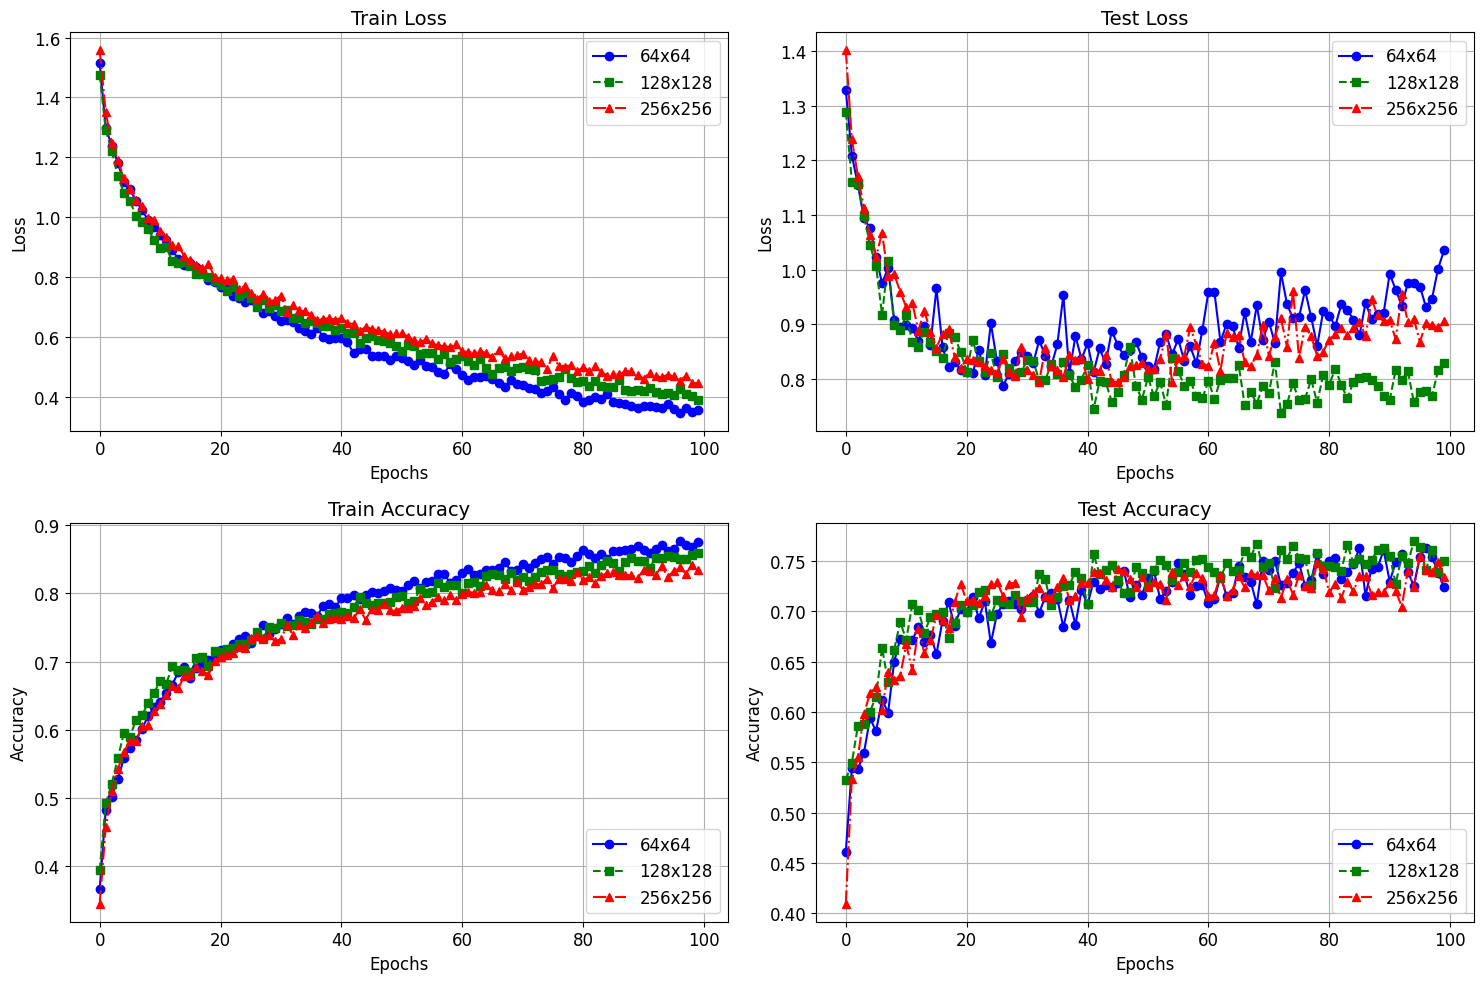

In [54]:
# Setup a plot with larger size for clarity
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(df_64x64_augment))

# Customize plot appearance
plt.rcParams.update({'font.size': 12})

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, df_64x64_augment["train_loss"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128_augment["train_loss"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256_augment["train_loss"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Train Loss", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(loc="upper right")

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, df_64x64_augment["test_loss"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128_augment["test_loss"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256_augment["test_loss"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Test Loss", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(loc="upper right")

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, df_64x64_augment["train_acc"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128_augment["train_acc"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256_augment["train_acc"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Train Accuracy", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc="lower right")

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, df_64x64_augment["test_acc"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128_augment["test_acc"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256_augment["test_acc"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Test Accuracy", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc="lower right")

# Adjust layout
plt.tight_layout()
plt.show()

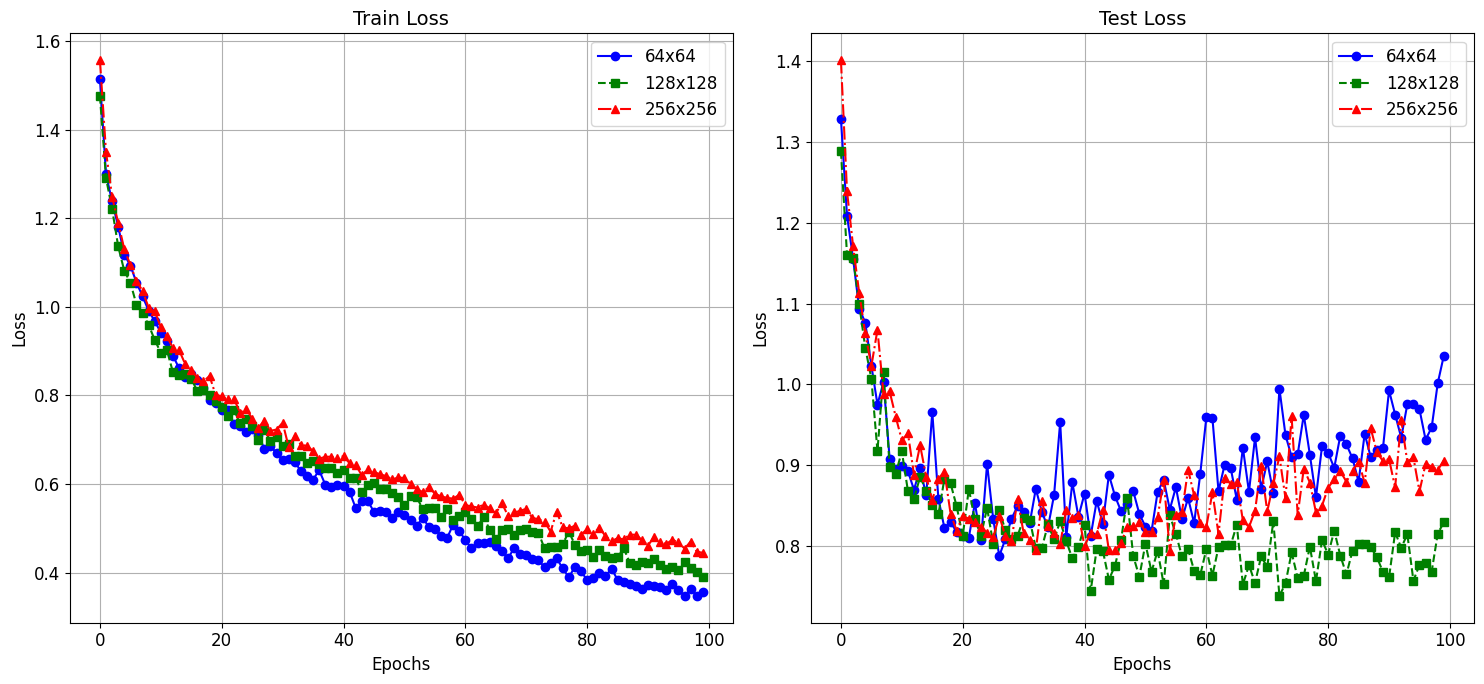

In [55]:
# Setup a plot with larger size for clarity
plt.figure(figsize=(15, 7))

# Get number of epochs
epochs = range(len(df_64x64_augment))

# Customize plot appearance
plt.rcParams.update({'font.size': 12})

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, df_64x64_augment["train_loss"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128_augment["train_loss"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256_augment["train_loss"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Train Loss", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(loc="upper right")

# Plot test loss
plt.subplot(1, 2, 2)
plt.plot(epochs, df_64x64_augment["test_loss"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128_augment["test_loss"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256_augment["test_loss"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Test Loss", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

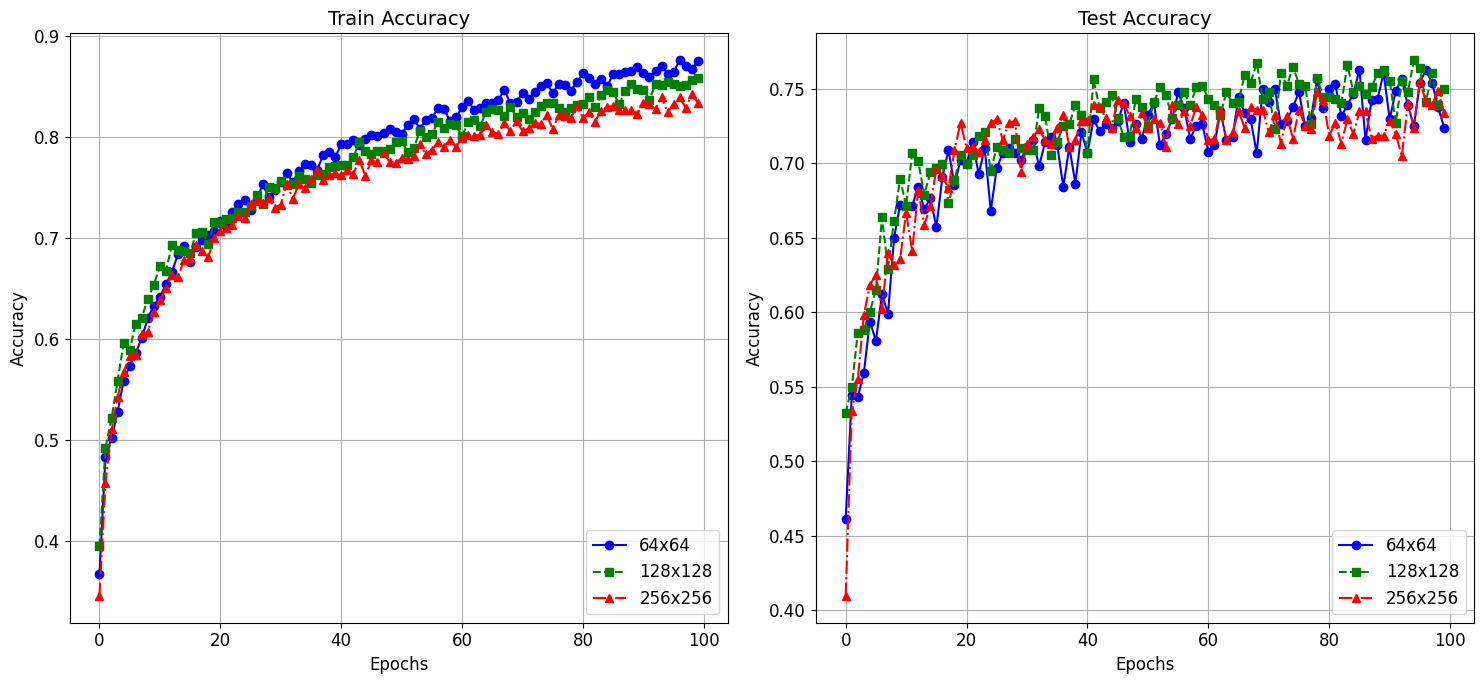

In [56]:
plt.figure(figsize=(15, 7))

# Get number of epochs
epochs = range(len(df_64x64_augment))

# Customize plot appearance
plt.rcParams.update({'font.size': 12})

# Plot train accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, df_64x64_augment["train_acc"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128_augment["train_acc"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256_augment["train_acc"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Train Accuracy", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc="lower right")

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, df_64x64_augment["test_acc"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128_augment["test_acc"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256_augment["test_acc"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Test Accuracy", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc="lower right")

# Adjust layout
plt.tight_layout()
plt.show()

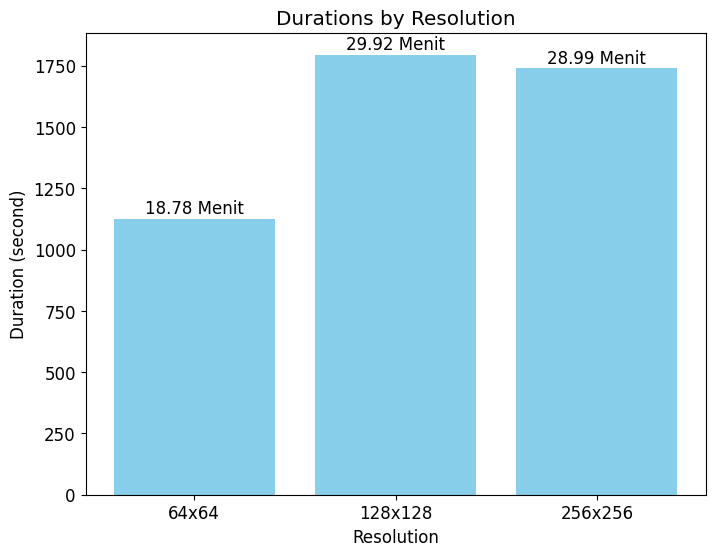

In [57]:
data_durasi = [duration_64x64_augment, duration_128x128_augment, duration_256x256_augment]
labels = ['64x64', '128x128', '256x256']

# Plotting histogram
plt.figure(figsize=(8,6))
bars = plt.bar(labels, data_durasi, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval/60:.2f} Menit', ha='center', va='bottom')


plt.xlabel('Resolution')
plt.ylabel('Duration (second)')
plt.title('Durations by Resolution')
plt.show()